In [46]:
# Define an Overwatch-themed color palette globally
overwatch_palette = ['#FF9C00', '#1C1C1C', '#FFFFFF', '#C0C0C0']  # Orange, Black, White, Gray

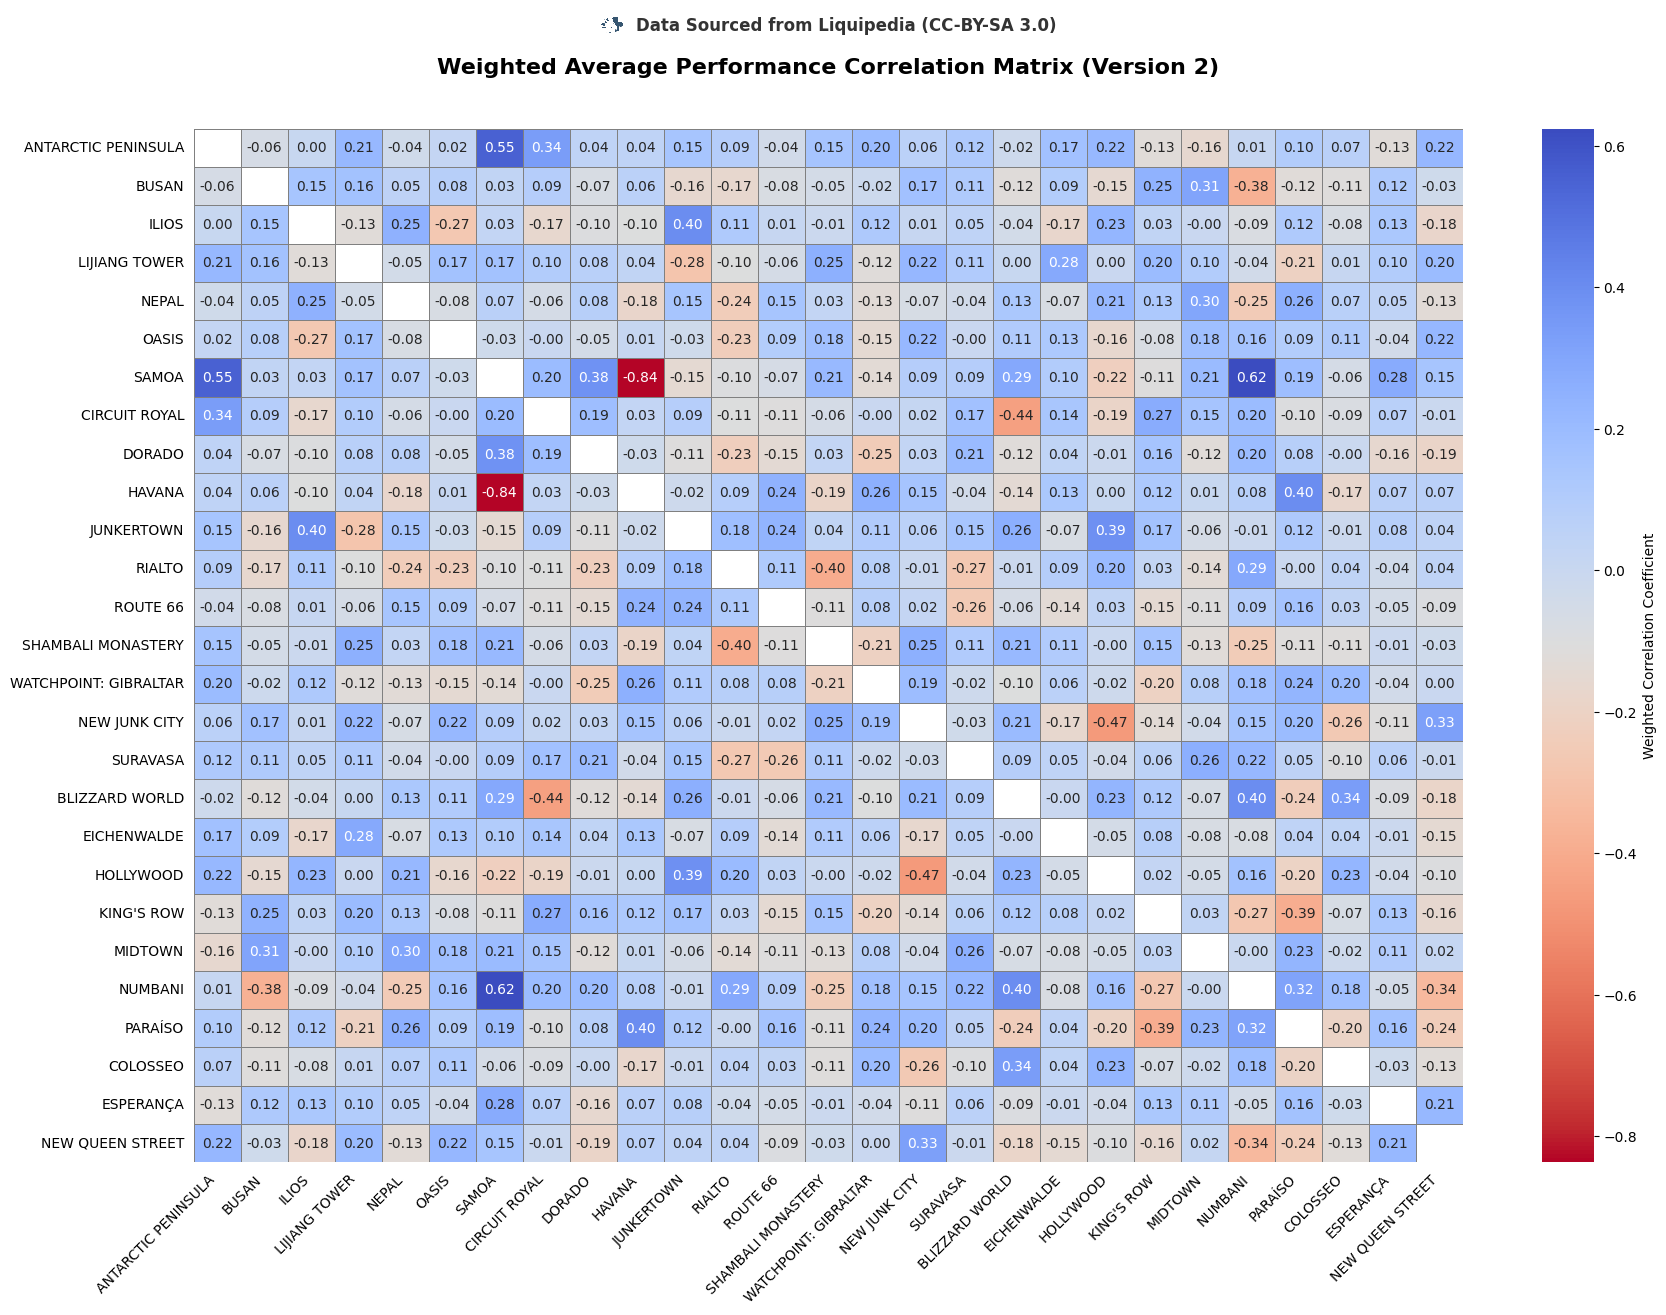

In [51]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea, HPacker

# Create a connection to the SQLite database
conn = sqlite3.connect('tournaments.db')

# Define the threshold for close ELO values
elo_threshold = 0.8  # You can adjust this value as needed

# Define the query using CTEs with filtering for version 2 and calculating the delta
query = f'''
WITH player_matches AS (
    SELECT DISTINCT
        tm.core_id,
        tm.team_id,
        mc.match_card_id,
        mc.team1_id,
        mc.team2_id,
        mc.winner,
        mc.team1_expected_outcome,
        mc.team2_expected_outcome
    FROM 
        team_members tm
    JOIN 
        match_cards mc 
    ON 
        tm.team_id = mc.team1_id OR tm.team_id = mc.team2_id
    WHERE 
        mc.version = 2 AND
        tm.role_type = 'player' AND
        ABS(mc.team1_expected_outcome - mc.team2_expected_outcome) < {elo_threshold}
),
player_map_performance AS (
    SELECT 
        pm.core_id,
        m.map,
        m.mode,
        m.score1,
        m.score2,
        m.winner,
        CASE 
            WHEN pm.team_id = mc.team1_id AND m.winner = 1 THEN 1 - mc.team1_expected_outcome
            WHEN pm.team_id = mc.team1_id AND m.winner = 2 THEN -mc.team1_expected_outcome
            WHEN pm.team_id = mc.team2_id AND m.winner = 2 THEN 1 - mc.team2_expected_outcome
            WHEN pm.team_id = mc.team2_id AND m.winner = 1 THEN -mc.team2_expected_outcome
            ELSE 0
        END AS performance_value
    FROM 
        player_matches pm
    JOIN 
        maps m 
    ON 
        pm.match_card_id = m.match_card_id
    JOIN 
        match_cards mc 
    ON 
        m.match_card_id = mc.match_card_id
    WHERE 
        m.map != 'HANAMURA'
)
SELECT 
    pmp.core_id,
    pmp.map,
    pmp.mode,
    COUNT(*) AS total_games,
    SUM(pmp.performance_value) AS total_performance,
    CAST(SUM(pmp.performance_value) AS FLOAT) / COUNT(*) AS average_performance
FROM 
    player_map_performance pmp
GROUP BY 
    pmp.core_id, pmp.map, pmp.mode;
'''

# Fetch results into a Pandas DataFrame
performance_df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Calculate total games per core_id
total_games_per_core_id = performance_df.groupby('core_id')['total_games'].sum().reset_index()

# Filter core_ids that meet the threshold of 20 matches
min_matches_threshold = 20
filtered_core_ids = total_games_per_core_id[total_games_per_core_id['total_games'] >= min_matches_threshold]['core_id']

# Filter the performance DataFrame to only include cores that meet the threshold
filtered_performance_df = performance_df[performance_df['core_id'].isin(filtered_core_ids)]

# Sort the maps by mode and then by map name
sorted_maps = filtered_performance_df[['map', 'mode']].drop_duplicates().sort_values(by=['mode', 'map'])

# Pivot the DataFrame to create a matrix of average performance and a matrix of game frequencies
performance_matrix = filtered_performance_df.pivot(index='core_id', columns='map', values='average_performance')
frequency_matrix = filtered_performance_df.pivot(index='core_id', columns='map', values='total_games')

# Reindex the matrices to reflect the sorted order of maps
performance_matrix = performance_matrix[sorted_maps['map']]
frequency_matrix = frequency_matrix[sorted_maps['map']]

# Fill NaN values with 0 for frequency matrix and with the average performance for performance matrix
performance_matrix = performance_matrix.fillna(performance_matrix.mean())
frequency_matrix = frequency_matrix.fillna(0)

# Calculate weighted performance
weighted_performance_matrix = performance_matrix * frequency_matrix

# Define a function to calculate the weighted correlation
def weighted_corr(x, y, w):
    """
    Calculate the weighted correlation between two variables.
    :param x: Array of first variable
    :param y: Array of second variable
    :param w: Array of weights
    :return: Weighted correlation coefficient
    """
    sum_w = np.sum(w)
    mean_x = np.sum(w * x) / sum_w
    mean_y = np.sum(w * y) / sum_w
    cov_xy = np.sum(w * (x - mean_x) * (y - mean_y)) / sum_w
    var_x = np.sum(w * (x - mean_x)**2) / sum_w
    var_y = np.sum(w * (y - mean_y)**2) / sum_w
    return cov_xy / np.sqrt(var_x * var_y)

# Calculate the weighted correlation matrix
maps = weighted_performance_matrix.columns
weighted_correlation_matrix = pd.DataFrame(index=maps, columns=maps)

for map1 in maps:
    for map2 in maps:
        if map1 == map2:
            weighted_correlation_matrix.loc[map1, map2] = np.nan
        else:
            valid_indices = (frequency_matrix[map1] > 0) & (frequency_matrix[map2] > 0)
            if valid_indices.sum() > 0:
                weighted_correlation_matrix.loc[map1, map2] = weighted_corr(
                    weighted_performance_matrix[map1][valid_indices],
                    weighted_performance_matrix[map2][valid_indices],
                    frequency_matrix[map1][valid_indices] + frequency_matrix[map2][valid_indices]
                )
            else:
                weighted_correlation_matrix.loc[map1, map2] = np.nan

weighted_correlation_matrix = weighted_correlation_matrix.astype(float)

plt.figure(figsize=(18, 14))  # Increase the figure size for better readability
ax = sns.heatmap(weighted_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm_r", cbar_kws={'label': 'Weighted Correlation Coefficient'}, annot_kws={"size": 10}, linewidths=.5, linecolor='grey')

# Add title with padding for space
plt.title('Weighted Average Performance Correlation Matrix (Version 2)', pad=40, fontsize=16, weight='bold')

# Adding Liquipedia logo and credit text inline
logo = plt.imread("liquipedia_logo.png")
imagebox = OffsetImage(logo, zoom=0.03, alpha=0.8)
text = TextArea("Data Sourced from Liquipedia (CC-BY-SA 3.0)", textprops=dict(color="black", fontsize=12, weight='bold', alpha=0.8))

# Use HPacker to combine the image and text horizontally
logo_and_text = HPacker(children=[imagebox, text], align="center", pad=5, sep=10)
ab = AnnotationBbox(logo_and_text, (0.5, 1.1), frameon=False, xycoords='axes fraction', boxcoords='axes fraction', pad=0)
ax.add_artist(ab)

# Rotate map names on the X-axis diagonally
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
ax.tick_params(left=False, bottom=False)  # Remove ticks from axes

# Remove default axis labels
ax.set(xlabel=None, ylabel=None)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



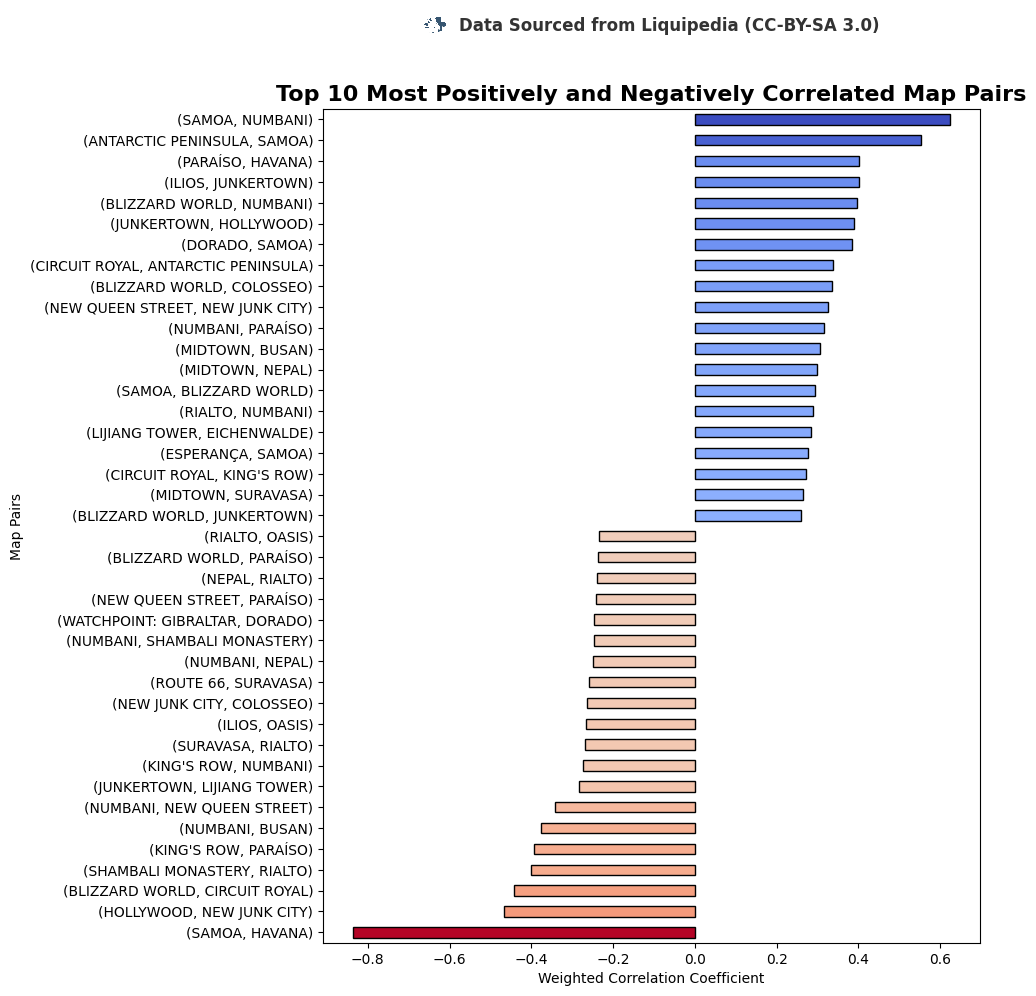

In [52]:
# Flatten the correlation matrix and sort by correlation values
correlation_series = weighted_correlation_matrix.unstack().dropna()

# Remove self correlations (correlation of a map with itself)
correlation_series = correlation_series[correlation_series.index.get_level_values(0) != correlation_series.index.get_level_values(1)]

# Sort by correlation values
sorted_correlations = correlation_series.sort_values()

# Remove every second value
sorted_correlations = sorted_correlations.iloc[::2]

# Extract top 10 negatively and positively correlated map pairs
top_neg_correlations = sorted_correlations.head(20)
top_pos_correlations = sorted_correlations.tail(20)

# Combine the results for display
combined_correlations = pd.concat([top_neg_correlations, top_pos_correlations])

# Plotting the results
plt.figure(figsize=(10, 10))
colors = plt.cm.coolwarm_r((combined_correlations - combined_correlations.min()) / (combined_correlations.max() - combined_correlations.min()))
combined_correlations.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Top 10 Most Positively and Negatively Correlated Map Pairs', fontsize=16, weight='bold')
plt.xlabel('Weighted Correlation Coefficient')
plt.ylabel('Map Pairs')

# Adding Liquipedia logo and credit text inline
logo = plt.imread("liquipedia_logo.png")
imagebox = OffsetImage(logo, zoom=0.03, alpha=0.8)
text = TextArea("Data Sourced from Liquipedia (CC-BY-SA 3.0)", textprops=dict(color="black", fontsize=12, weight='bold', alpha=0.8))

# Use HPacker to combine the image and text horizontally
logo_and_text = HPacker(children=[imagebox, text], align="center", pad=5, sep=10)
ab = AnnotationBbox(logo_and_text, (0.5, 1.1), frameon=False, xycoords='axes fraction', boxcoords='axes fraction', pad=0)
plt.gca().add_artist(ab)

plt.tight_layout()
plt.show()


                      map  correlation
0     ANTARCTIC PENINSULA     0.072419
1          BLIZZARD WORLD     0.035437
2                   BUSAN    -0.004225
3           CIRCUIT ROYAL     0.047603
4                COLOSSEO     0.083622
5                  DORADO    -0.069659
6             EICHENWALDE    -0.023953
7               ESPERANÇA     0.013028
8                  HAVANA     0.059338
9               HOLLYWOOD    -0.001197
10                  ILIOS     0.056251
11             JUNKERTOWN    -0.013532
12             KING'S ROW     0.111242
13          LIJIANG TOWER     0.010244
14                MIDTOWN     0.009903
15                  NEPAL     0.048646
16          NEW JUNK CITY     0.072671
17       NEW QUEEN STREET     0.018344
18                NUMBANI     0.049430
19                  OASIS     0.028000
20                PARAÍSO     0.068334
21                 RIALTO     0.037951
22               ROUTE 66     0.015115
23                  SAMOA    -0.046594
24     SHAMBALI MONASTERY

C:\Users\jorda\AppData\Local\Temp\ipykernel_24124\3961453944.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = performance_and_frequency.groupby('map').apply(lambda df: df['average_performance'].corr(df['total_games'])).reset_index()


<Figure size 1400x1000 with 0 Axes>

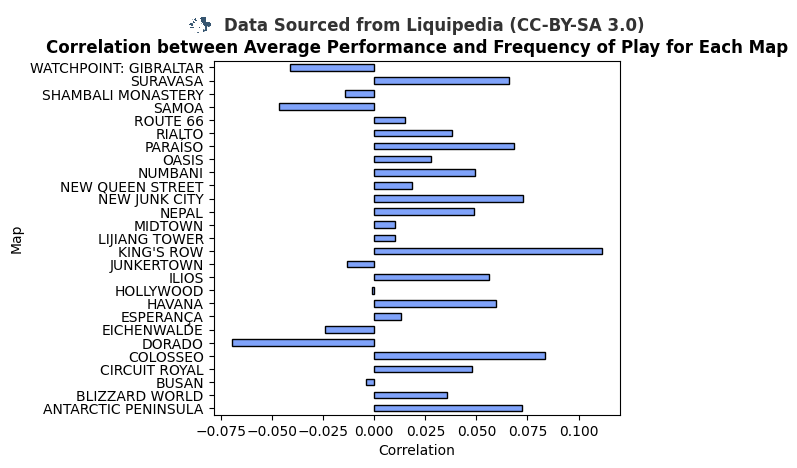

In [53]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea, HPacker

# Create a connection to the SQLite database
conn = sqlite3.connect('tournaments.db')

# Define the query using CTEs with filtering for version 2 and calculating the delta
query = '''
WITH player_matches AS (
    SELECT DISTINCT
        tm.core_id,
        tm.team_id,
        mc.match_card_id,
        mc.team1_id,
        mc.team2_id,
        mc.winner,
        mc.team1_expected_outcome,
        mc.team2_expected_outcome
    FROM 
        team_members tm
    JOIN 
        match_cards mc 
    ON 
        tm.team_id = mc.team1_id OR tm.team_id = mc.team2_id
    WHERE 
        mc.version = 2 AND
        tm.role_type = 'player'
),
player_map_performance AS (
    SELECT 
        pm.core_id,
        m.map,
        m.mode,
        m.score1,
        m.score2,
        m.winner,
        CASE 
            WHEN pm.team_id = mc.team1_id AND m.winner = 1 THEN 1 - mc.team1_expected_outcome
            WHEN pm.team_id = mc.team1_id AND m.winner = 2 THEN -mc.team1_expected_outcome
            WHEN pm.team_id = mc.team2_id AND m.winner = 2 THEN 1 - mc.team2_expected_outcome
            WHEN pm.team_id = mc.team2_id AND m.winner = 1 THEN -mc.team2_expected_outcome
            ELSE 0
        END AS performance_value
    FROM 
        player_matches pm
    JOIN 
        maps m 
    ON 
        pm.match_card_id = m.match_card_id
    JOIN 
        match_cards mc 
    ON 
        m.match_card_id = mc.match_card_id
    WHERE 
        m.map != 'HANAMURA'
)
SELECT 
    pmp.core_id,
    pmp.map,
    pmp.mode,
    COUNT(*) AS total_games,
    SUM(pmp.performance_value) AS total_performance,
    CAST(SUM(pmp.performance_value) AS FLOAT) / COUNT(*) AS average_performance
FROM 
    player_map_performance pmp
GROUP BY 
    pmp.core_id, pmp.map, pmp.mode;
'''

# Fetch results into a Pandas DataFrame
performance_df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Calculate total games per core_id per map
total_games_per_core_map = performance_df.groupby(['core_id', 'map'])['total_games'].sum().reset_index()

# Filter core_ids that meet the threshold of 20 matches overall
total_games_per_core_id = total_games_per_core_map.groupby('core_id')['total_games'].sum().reset_index()
min_matches_threshold = 20
filtered_core_ids = total_games_per_core_id[total_games_per_core_id['total_games'] >= min_matches_threshold]['core_id']
filtered_performance_df = performance_df[performance_df['core_id'].isin(filtered_core_ids)]

# Calculate the frequency of play per core_id per map
frequency_of_play = filtered_performance_df.groupby(['core_id', 'map'])['total_games'].sum().reset_index()
frequency_of_play.columns = ['core_id', 'map', 'total_games']

# Calculate the average performance per core_id per map
average_performance_per_core_map = filtered_performance_df.groupby(['core_id', 'map'])['average_performance'].mean().reset_index()
average_performance_per_core_map.columns = ['core_id', 'map', 'average_performance']

# Merge the average performance with frequency of play
performance_and_frequency = pd.merge(average_performance_per_core_map, frequency_of_play, on=['core_id', 'map'])

# Calculate the correlation for each map
correlations = performance_and_frequency.groupby('map').apply(lambda df: df['average_performance'].corr(df['total_games'])).reset_index()
correlations.columns = ['map', 'correlation']

# Print the correlations
print(correlations)

# Plot the correlation for each map
plt.figure(figsize=(14, 10))
colors = plt.cm.coolwarm_r((correlations['correlation'] - correlations['correlation'].min()) / (correlations['correlation'].max() - correlations['correlation'].min()))
correlations.set_index('map').plot(kind='barh', color=colors, edgecolor='black', legend=False)
plt.title('Correlation between Average Performance and Frequency of Play for Each Map', fontsize=12, weight='bold')
plt.xlabel('Correlation')
plt.ylabel('Map')
plt.grid(False)

# Adding Liquipedia logo and credit text inline
logo = plt.imread("liquipedia_logo.png")
imagebox = OffsetImage(logo, zoom=0.03, alpha=0.8)
text = TextArea("Data Sourced from Liquipedia (CC-BY-SA 3.0)", textprops=dict(color="black", fontsize=12, weight='bold', alpha=0.8))

# Use HPacker to combine the image and text horizontally
logo_and_text = HPacker(children=[imagebox, text], align="center", pad=5, sep=10)
ab = AnnotationBbox(logo_and_text, (0.5, 1.1), frameon=False, xycoords='axes fraction', boxcoords='axes fraction', pad=0)
plt.gca().add_artist(ab)

plt.tight_layout()
plt.show()

